In [1]:
from cmdstanpy import CmdStanModel, from_csv

from seaborn import jointplot
import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import pandas as pd
import os
import glob

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load data
df = pd.read_csv('delivery_time_data.csv', delimiter=';', decimal=',')

df = df[df["Road distances [km]"] < 20]

# TEMP: only for testing plots and functions
train_df = pd.DataFrame(df.iloc[:, :])

# normalized distance
train_df["Normalized distances"] = (train_df["Road distances [km]"] - train_df["Road distances [km]"].mean()) / train_df["Road distances [km]"].std()

# normalized meal preparation time
train_df["Normalized mealprep"] = (train_df["Meal_preparation_time"] - train_df["Meal_preparation_time"].mean()) / train_df["Meal_preparation_time"].std()

# map categorical traffic density to numbers
road_density_map = {'Jam ':1, 'High ':2, 'Medium ':3, 'Low ':4}

train_df["Road_traffic_density"] = train_df["Road_traffic_density"].apply(lambda x: road_density_map[x])

#------------------------------------------------------- parameters exclusive for model 2 --------------------------------------------------

# delivery person rating
train_df["Normalized person_rating"] = (train_df["Delivery_person_Ratings"] - train_df["Delivery_person_Ratings"].mean()) / train_df["Delivery_person_Ratings"].std()

# number of deliveries
train_df["multiple_deliveries"] = train_df["multiple_deliveries"]+1


# PPC AND FIT - MODEL 1

In [3]:
# remove previously sampled ppc for model 1
files = glob.glob('models_output/model1/ppc/*')
for f in files:
    os.remove(f)

model1_ppc=CmdStanModel(stan_file='model1_ppc.stan')

model1_ppc_sim=model1_ppc.sample(data={"N": len(train_df), "distance": train_df["Normalized distances"].values,
                           "meal_preparation_time": train_df["Normalized mealprep"].values,
                           "traffic_level" :train_df["Road_traffic_density"].values}, 
                     iter_sampling=1000,
                     iter_warmup=0, 
                     chains=1, 
                     fixed_param=True,
                     seed=20230613,
                     output_dir='models_output/model1/ppc/')


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:35 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


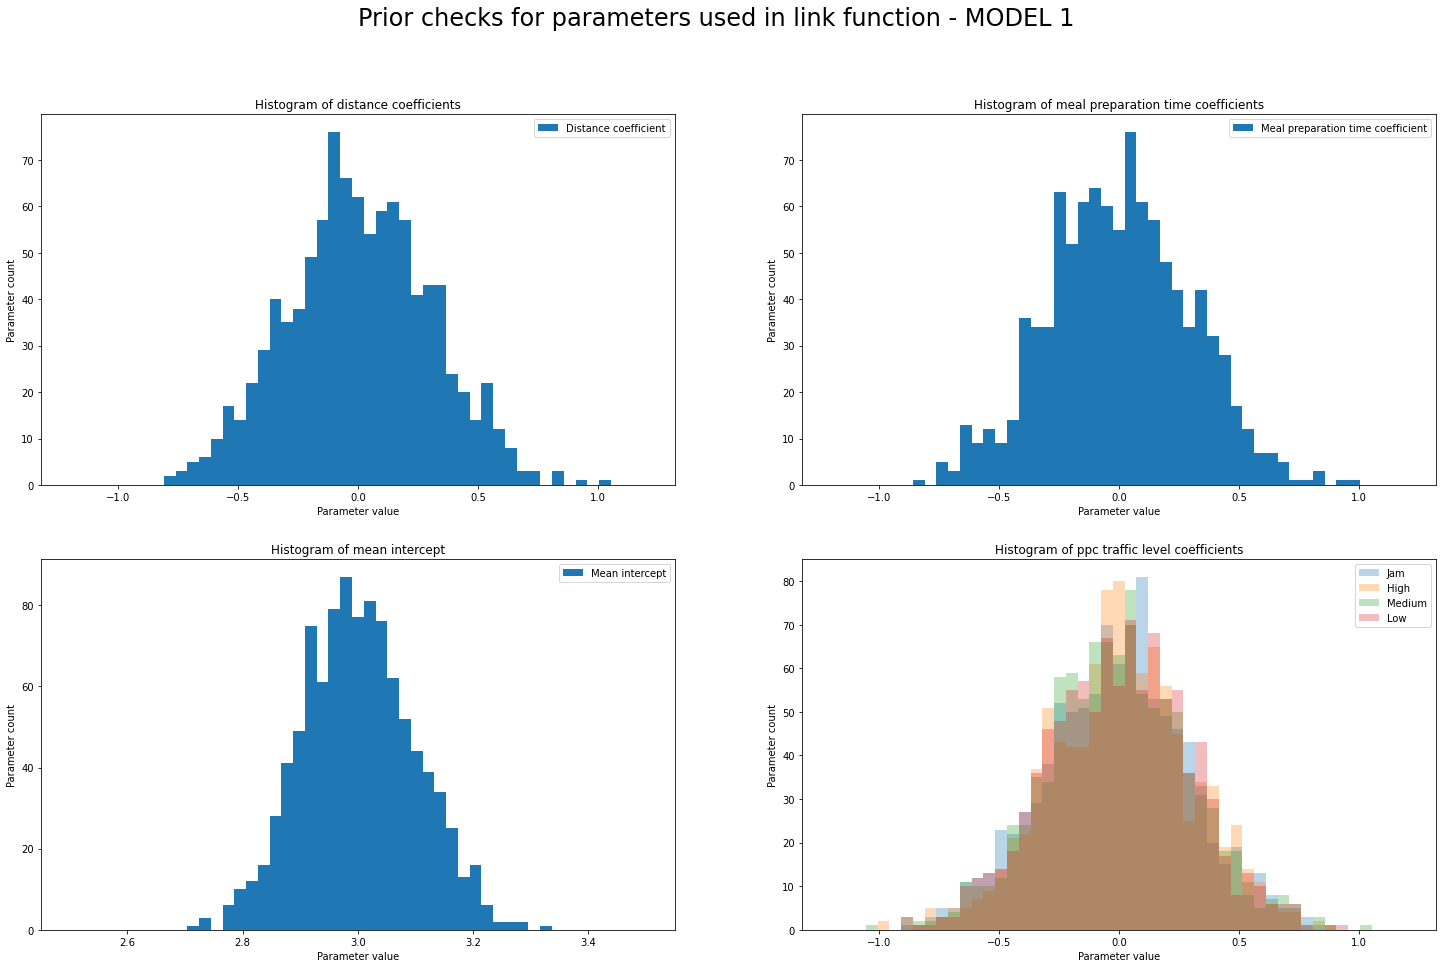

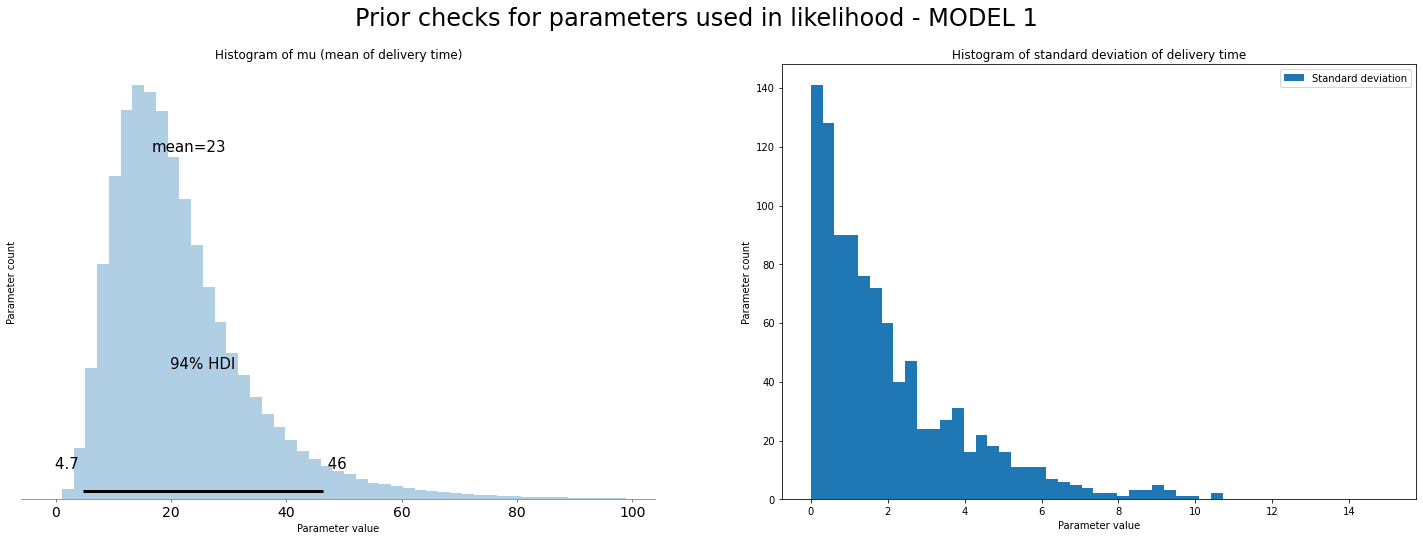

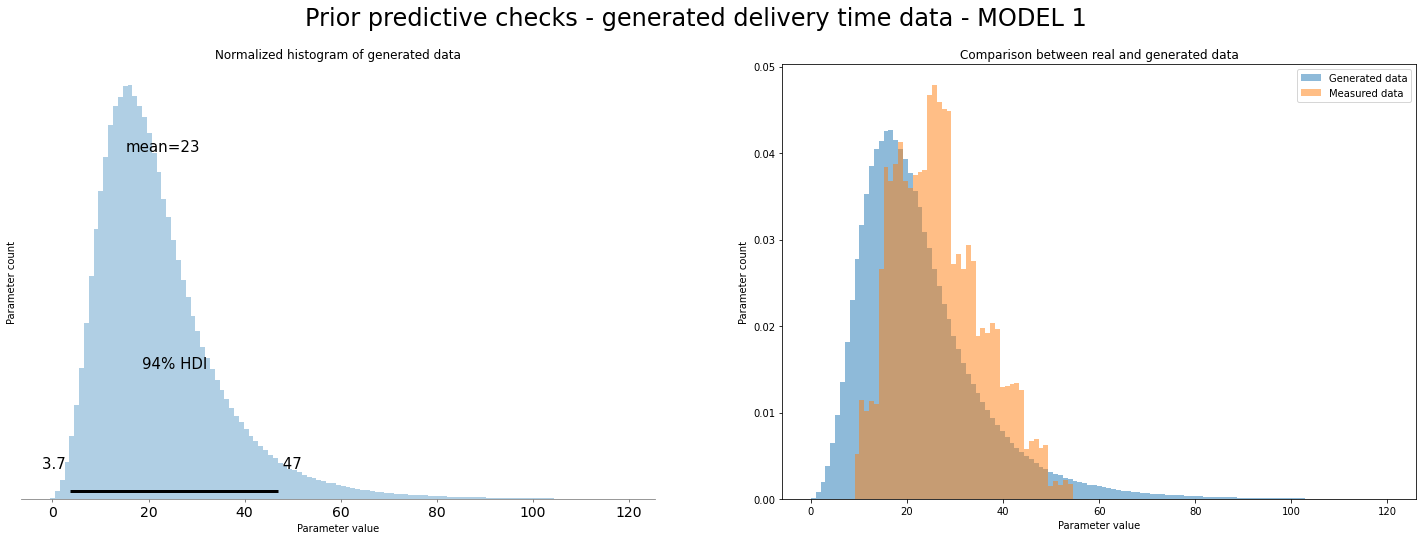

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
count,56469.000000,56468.000000,56469.000000,56469.000000,56469.000000,56469.000000,56468.000000,56468.000000,56468.0
mean,23.054579,0.433047,13.060379,8.397020,20.018018,47.765982,915.336757,25.567105,1.0
std,1.356239,0.118980,3.594003,1.495627,0.436726,7.942118,90.827019,2.559224,0.0
min,-0.009100,0.003100,0.000000,-0.530000,-0.009400,0.000000,573.000000,16.000000,1.0
25%,22.000000,0.370000,11.000000,7.300000,20.000000,44.000000,880.000000,25.000000,1.0
50%,23.000000,0.420000,13.000000,8.300000,20.000000,47.000000,927.000000,26.000000,1.0
75%,24.000000,0.510000,15.000000,9.200000,20.000000,53.000000,967.000000,27.000000,1.0
max,28.000000,0.890000,27.000000,12.000000,22.000000,78.000000,1166.000000,33.000000,1.0


In [4]:
# plot preparation
fig, ax = plt.subplots(2,2, figsize=(25,15))
fig.suptitle("Prior checks for parameters used in link function - MODEL 1", fontsize=24)

# get distance coeff
model1_ppc_distance_coeff = model1_ppc_sim.stan_variable('distance_coeff')

# plot distance coeff
ax[0,0].hist(model1_ppc_distance_coeff,label="Distance coefficient", bins=np.linspace(-1.2,1.2,50))
ax[0,0].legend()
ax[0,0].set_xlabel("Parameter value")
ax[0,0].set_ylabel("Parameter count")
ax[0,0].set_title("Histogram of distance coefficients")

# get meal_prep_coeff coeff
model1_ppc_meal_prep_coeff = model1_ppc_sim.stan_variable('meal_prep_coeff')

# plot meal_prep_coeff coeff
ax[0,1].hist(model1_ppc_meal_prep_coeff,label="Meal preparation time coefficient", bins=np.linspace(-1.2,1.2,50))
ax[0,1].legend()
ax[0,1].set_xlabel("Parameter value")
ax[0,1].set_ylabel("Parameter count")
ax[0,1].set_title("Histogram of meal preparation time coefficients")

# get mean
model1_ppc_mean = model1_ppc_sim.stan_variable('mean')

# plot mean
ax[1,0].hist(model1_ppc_mean,label="Mean intercept", bins=np.linspace(2.5,3.5,50))
ax[1,0].legend()
ax[1,0].set_xlabel("Parameter value")
ax[1,0].set_ylabel("Parameter count")
ax[1,0].set_title("Histogram of mean intercept")

# get traffic level coeff
model1_ppc_traffic_coeff = model1_ppc_sim.stan_variable('traffic_level_coeff')

# plot traffic coeff
ax[1,1].hist(model1_ppc_traffic_coeff[:,0],label="Jam", alpha=0.3, bins=np.linspace(-1.2,1.2,50))
ax[1,1].hist(model1_ppc_traffic_coeff[:,1],label="High", alpha=0.3, bins=np.linspace(-1.2,1.2,50))
ax[1,1].hist(model1_ppc_traffic_coeff[:,2],label="Medium", alpha=0.3, bins=np.linspace(-1.2,1.2,50))
ax[1,1].hist(model1_ppc_traffic_coeff[:,3],label="Low", alpha=0.3, bins=np.linspace(-1.2,1.2,50))
ax[1,1].legend()
ax[1,1].set_xlabel("Parameter value")
ax[1,1].set_ylabel("Parameter count")
ax[1,1].set_title("Histogram of ppc traffic level coefficients")
plt.show()

#-------------------------------------PARAMS FOR MODEL-------------------------------------------------
# plot preparation
fig1, ax1= plt.subplots(1,2, figsize=(25,8))
fig1.suptitle("Prior checks for parameters used in likelihood - MODEL 1", fontsize=24)

# get distance coeff (flatten because its MxN matrix (data samples x algo samples))
model1_ppc_mu = model1_ppc_sim.stan_variable('mu').flatten()

# plot distance coeff
az.plot_posterior(model1_ppc_mu, kind='hist', ax=ax1[0], bins=np.linspace(0,100,50), group='prior')
ax1[0].set_frame_on(True)
ax1[0].set_xlabel("Parameter value")
ax1[0].set_ylabel("Parameter count")
ax1[0].set_title("Histogram of mu (mean of delivery time)")

# get meal_prep_coeff coeff
model1_ppc_sigma = model1_ppc_sim.stan_variable('sigma')

# plot meal_prep_coeff coeff
ax1[1].hist(model1_ppc_sigma,label="Standard deviation", bins=np.linspace(0,15,50))
ax1[1].legend()
ax1[1].set_xlabel("Parameter value")
ax1[1].set_ylabel("Parameter count")
ax1[1].set_title("Histogram of standard deviation of delivery time")
plt.show()

#--------------------------------------PPC MEASUREMENTS------------------------------------------------------

fig2, ax2= plt.subplots(1,2, figsize=(25,8))
fig2.suptitle("Prior predictive checks - generated delivery time data - MODEL 1", fontsize=24)

# get measurements
model1_ppc_measurements = model1_ppc_sim.stan_variable('delivery_times').flatten()  # flatten makes it row/column vector (one of these)

# set bins
bins = np.linspace(0, 120, 120)

az.plot_posterior(model1_ppc_measurements, kind='hist', ax=ax2[0], bins=bins, group='prior', backend="matplotlib")
ax2[0].set_xlabel("Parameter value")
ax2[0].set_ylabel("Parameter count")
ax2[0].set_title("Normalized histogram of generated data")

# plot measurements
ax2[1].hist(model1_ppc_measurements, density=True, bins=bins,  alpha=0.5, label="Generated data")

# compare with real data, density set to True because each data point sampled 999 times
ax2[1].hist(train_df["Time_taken(min)"], density=True, bins=bins, alpha=0.5, label="Measured data")
ax2[1].legend()
ax2[1].set_xlabel("Parameter value")
ax2[1].set_ylabel("Parameter count")
ax2[1].set_title("Comparison between real and generated data")
plt.show()

# display summary
model1_ppc_sim.summary().describe()


In [5]:
# load model from previously sampled csvs
model1_sample = from_csv('/home/project_repo/data_analytics_project/models_output/model1/fit')

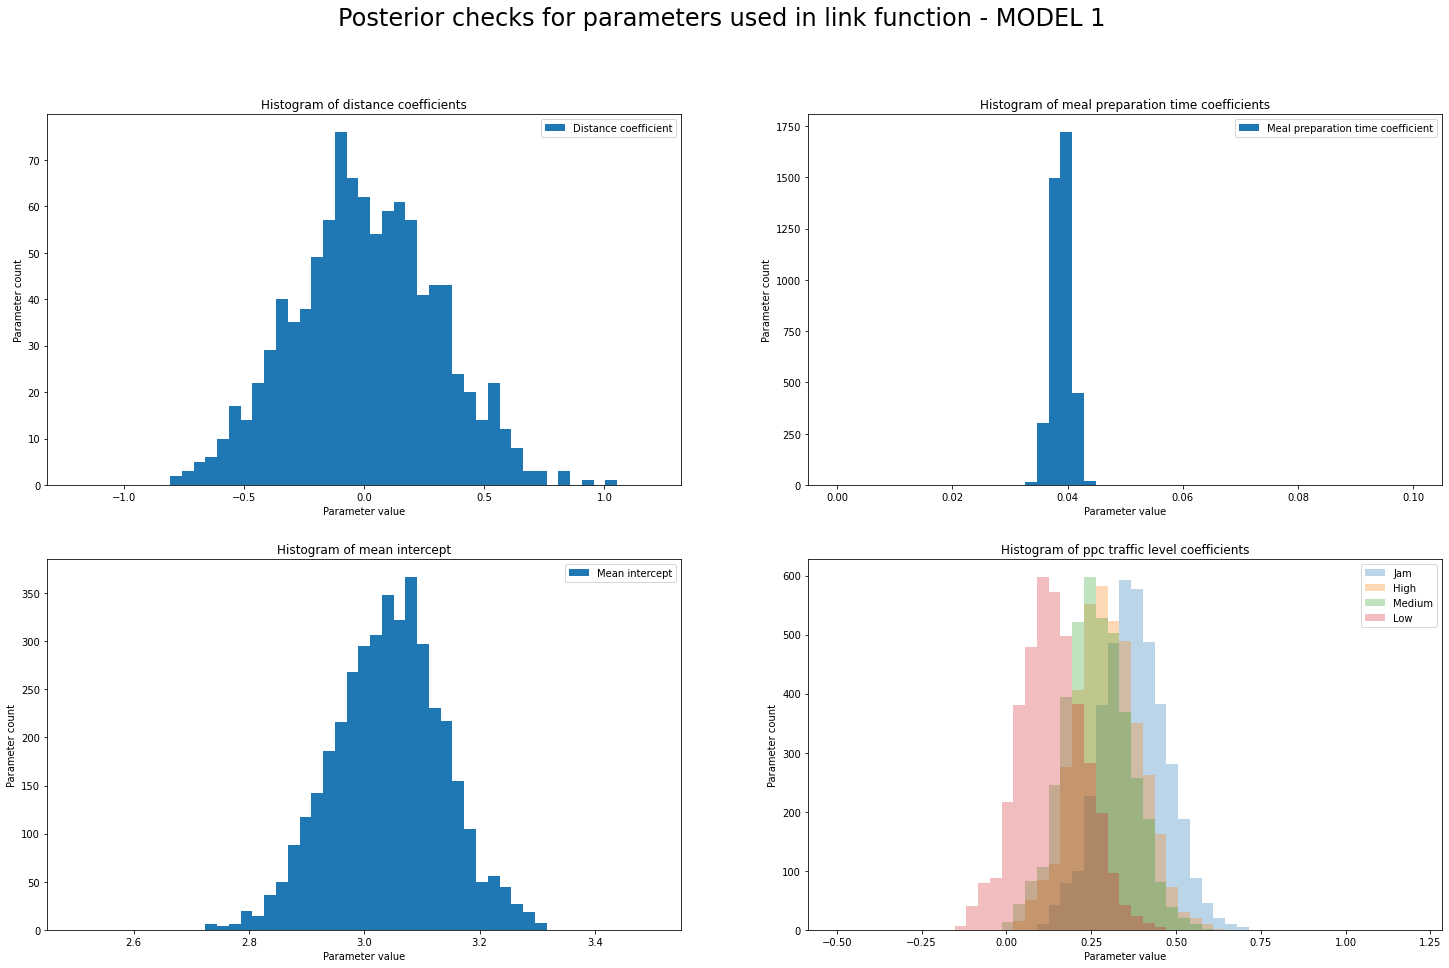

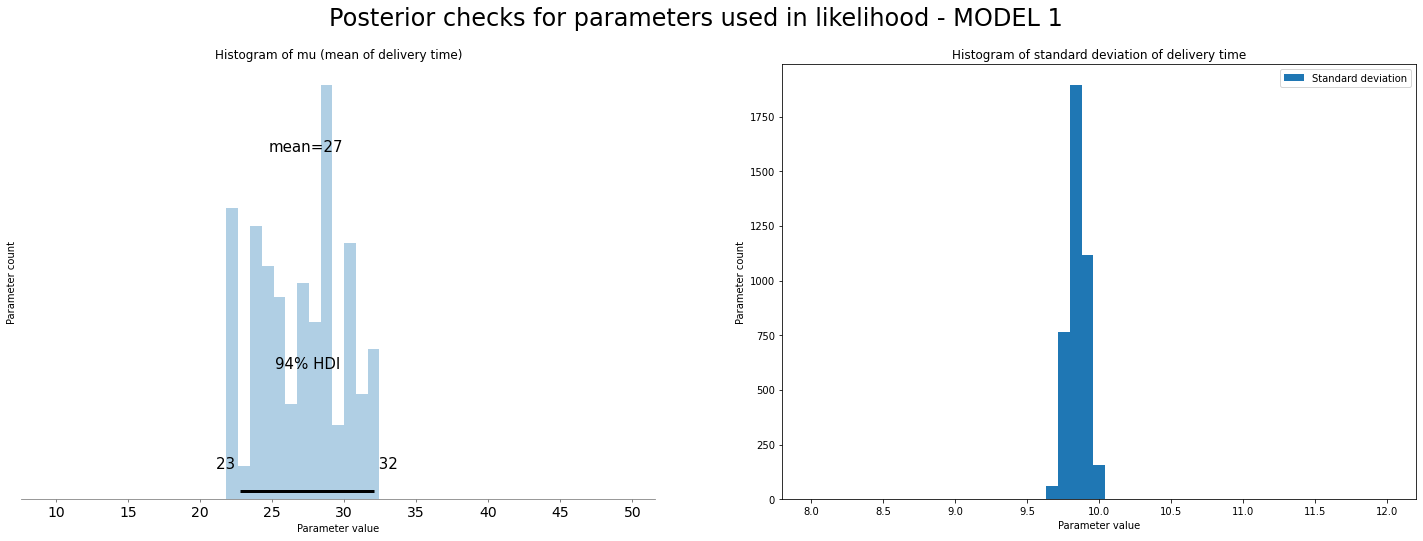

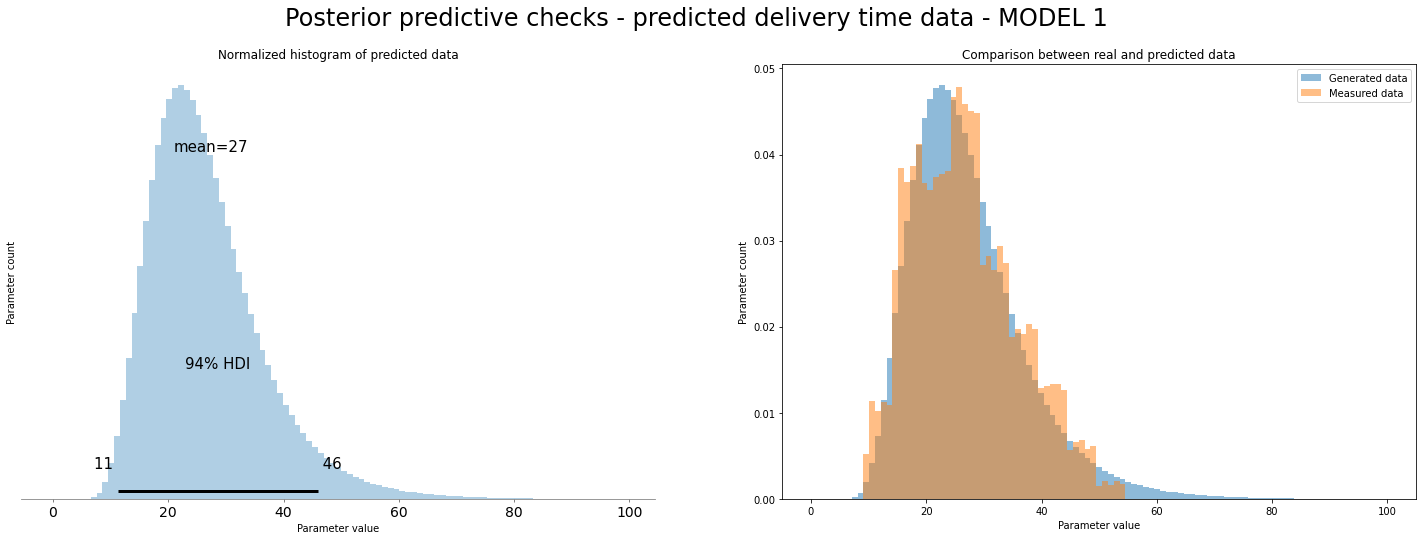

In [6]:
# plot preparation
fig, ax = plt.subplots(2,2, figsize=(25,15))
fig.suptitle("Posterior checks for parameters used in link function - MODEL 1", fontsize=24)

# get distance coeff
model1_fit_distance_coeff = model1_sample.stan_variable('distance_coeff')

# plot distance coeff
ax[0,0].hist(model1_ppc_distance_coeff,label="Distance coefficient", bins=np.linspace(-1.2,1.2,50))
ax[0,0].legend()
ax[0,0].set_xlabel("Parameter value")
ax[0,0].set_ylabel("Parameter count")
ax[0,0].set_title("Histogram of distance coefficients")

# get meal_prep_coeff coeff
model1_fit_meal_prep_coeff = model1_sample.stan_variable('meal_prep_coeff')

# plot meal_prep_coeff coeff
ax[0,1].hist(model1_fit_meal_prep_coeff,label="Meal preparation time coefficient", bins=np.linspace(0,0.1,50))
ax[0,1].legend()
ax[0,1].set_xlabel("Parameter value")
ax[0,1].set_ylabel("Parameter count")
ax[0,1].set_title("Histogram of meal preparation time coefficients")

# get mean
model1_fit_mean = model1_sample.stan_variable('mean')

# plot mean
ax[1,0].hist(model1_fit_mean,label="Mean intercept", bins=np.linspace(2.5,3.5,50))
ax[1,0].legend()
ax[1,0].set_xlabel("Parameter value")
ax[1,0].set_ylabel("Parameter count")
ax[1,0].set_title("Histogram of mean intercept")

# get traffic level coeff
model1_fit_traffic_coeff = model1_sample.stan_variable('traffic_level_coeff')

# plot traffic coeff
ax[1,1].hist(model1_fit_traffic_coeff[:,0],label="Jam", alpha=0.3, bins=np.linspace(-0.5,1.2,50))
ax[1,1].hist(model1_fit_traffic_coeff[:,1],label="High", alpha=0.3, bins=np.linspace(-0.5,1.2,50))
ax[1,1].hist(model1_fit_traffic_coeff[:,2],label="Medium", alpha=0.3, bins=np.linspace(-0.5,1.2,50))
ax[1,1].hist(model1_fit_traffic_coeff[:,3],label="Low", alpha=0.3, bins=np.linspace(-0.5,1.2,50))
ax[1,1].legend()
ax[1,1].set_xlabel("Parameter value")
ax[1,1].set_ylabel("Parameter count")
ax[1,1].set_title("Histogram of ppc traffic level coefficients")
plt.show()

#-------------------------------------PARAMS FOR MODEL-------------------------------------------------
# plot preparation
fig1, ax1= plt.subplots(1,2, figsize=(25,8))
fig1.suptitle("Posterior checks for parameters used in likelihood - MODEL 1", fontsize=24)

# get distance coeff (flatten because its MxN matrix (data samples x algo samples))
model1_fit_mu = model1_sample.stan_variable('mu').flatten()

# plot distance coeff
az.plot_posterior(model1_fit_mu, kind='hist', ax=ax1[0], bins=np.linspace(10,50,50), group='prior')
ax1[0].set_frame_on(True)
ax1[0].set_xlabel("Parameter value")
ax1[0].set_ylabel("Parameter count")
ax1[0].set_title("Histogram of mu (mean of delivery time)")

# get meal_prep_coeff coeff
model1_fit_sigma = model1_sample.stan_variable('sigma')

# plot meal_prep_coeff coeff
ax1[1].hist(model1_fit_sigma,label="Standard deviation", bins=np.linspace(8,12,50))
ax1[1].legend()
ax1[1].set_xlabel("Parameter value")
ax1[1].set_ylabel("Parameter count")
ax1[1].set_title("Histogram of standard deviation of delivery time")
plt.show()

#--------------------------------------PPC MEASUREMENTS------------------------------------------------------

fig2, ax2= plt.subplots(1,2, figsize=(25,8))
fig2.suptitle("Posterior predictive checks - predicted delivery time data - MODEL 1", fontsize=24)

# get measurements
model1_fit_measurements = model1_sample.stan_variable('delivery_time').flatten()  # flatten makes it row/column vector (one of these)

# set bins
bins = np.linspace(0, 100, 100)

az.plot_posterior(model1_fit_measurements, kind='hist', ax=ax2[0], bins=bins, group='prior', backend="matplotlib")
ax2[0].set_xlabel("Parameter value")
ax2[0].set_ylabel("Parameter count")
ax2[0].set_title("Normalized histogram of predicted data")

# plot measurements
ax2[1].hist(model1_fit_measurements, density=True, bins=bins,  alpha=0.5, label="Generated data")

# compare with real data, density set to True because each data point sampled 999 times
ax2[1].hist(train_df["Time_taken(min)"], density=True, bins=bins, alpha=0.5, label="Measured data")
ax2[1].legend()
ax2[1].set_xlabel("Parameter value")
ax2[1].set_ylabel("Parameter count")
ax2[1].set_title("Comparison between real and predicted data")
plt.show()

# display summary
model1_sample.summary()

# delete model 1 from memory (it weighs around 4GBs...)
del model1_sample

# PPC AND FIT - MODEL 2

In [7]:
# remove previously sampled ppc for model 2
files = glob.glob('models_output/model2/ppc/*')
for f in files:
    os.remove(f)

model2_ppc=CmdStanModel(stan_file='model2_ppc.stan')

model2_ppc_sim=model2_ppc.sample(data={"N": len(train_df), "distance": train_df["Normalized distances"].values,
                           "meal_preparation_time": train_df["Normalized mealprep"].values,
                           "traffic_level": train_df["Road_traffic_density"].values,
                           "delivery_person_rating": train_df["Normalized person_rating"].values,
                           "number_of_deliveries": train_df["multiple_deliveries"].values}, 
                     iter_sampling=1000,
                     iter_warmup=0, 
                     chains=1, 
                     fixed_param=True,
                     seed=20230613,
                     output_dir='models_output/model2/ppc/')

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:36 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


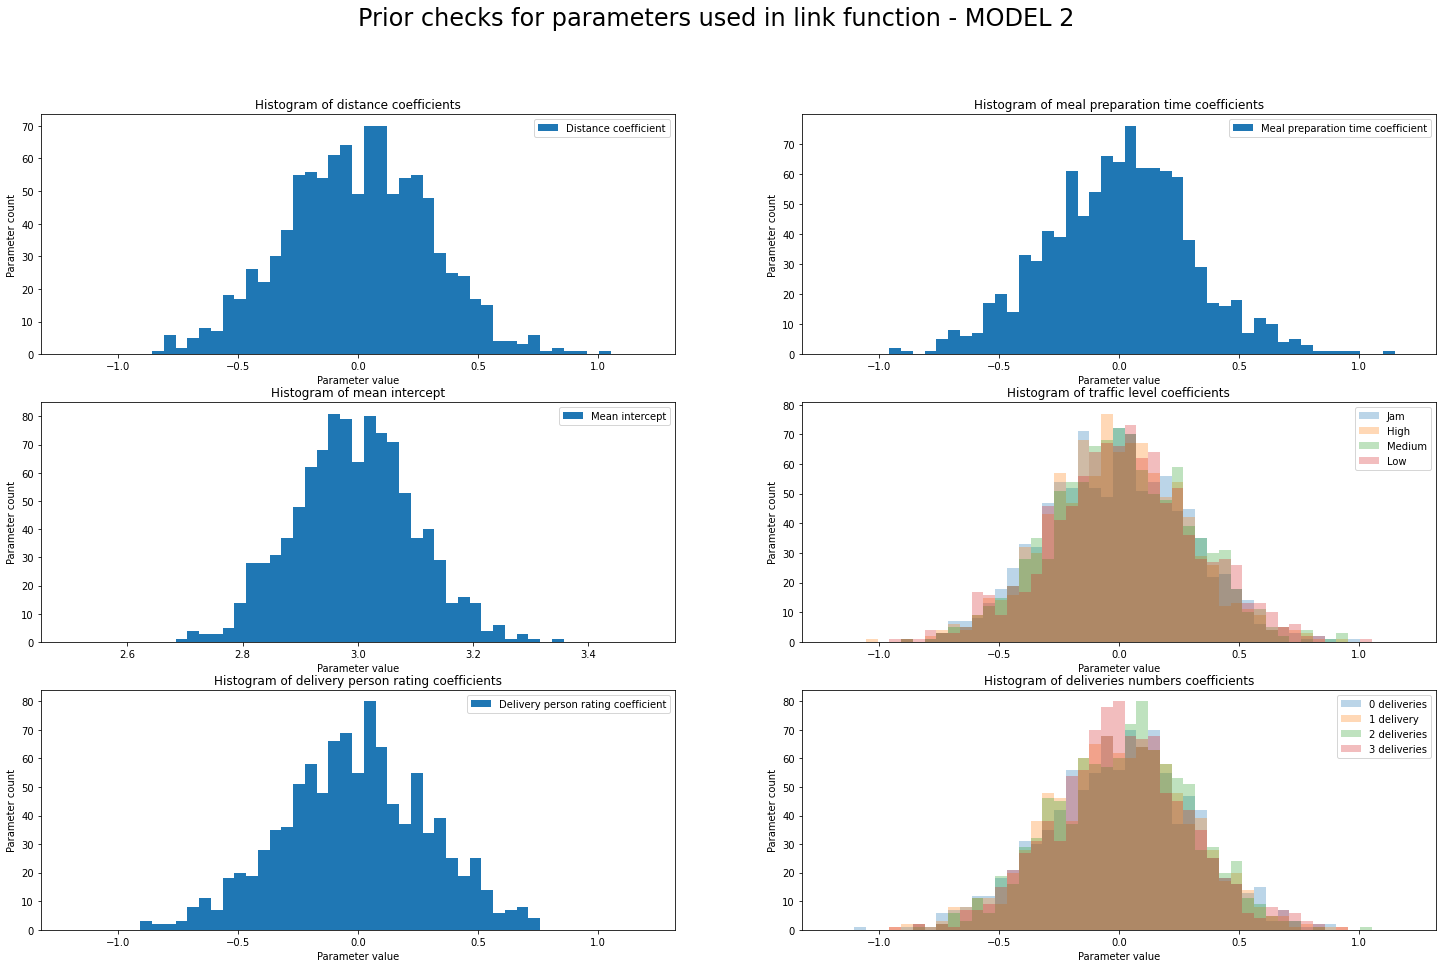

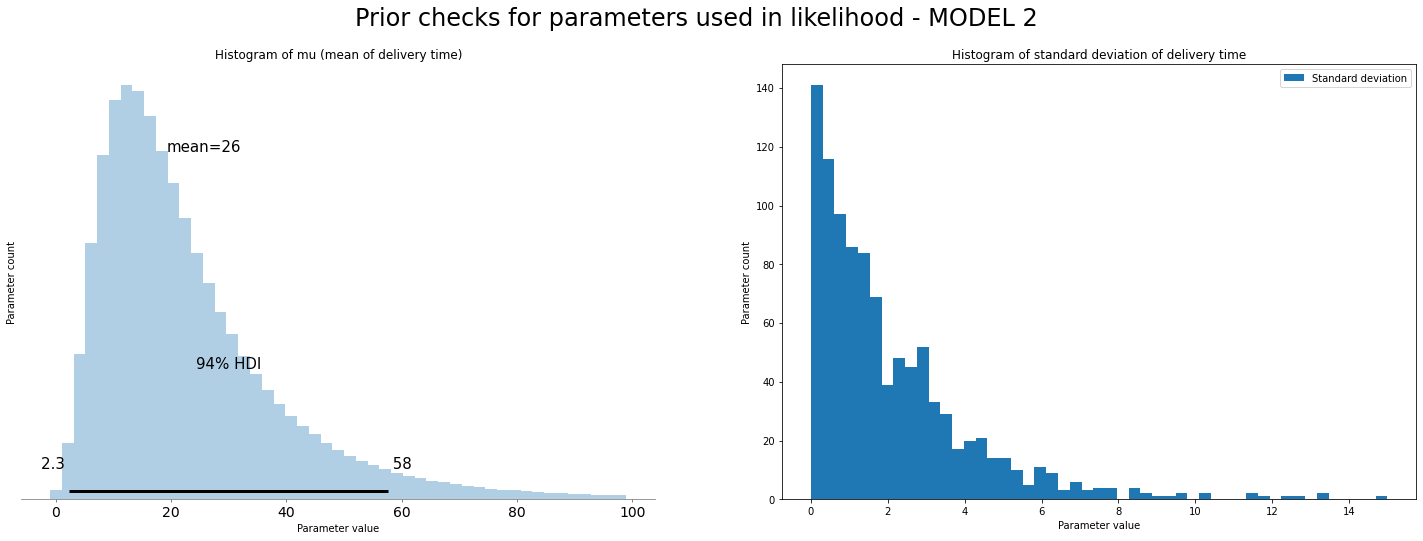

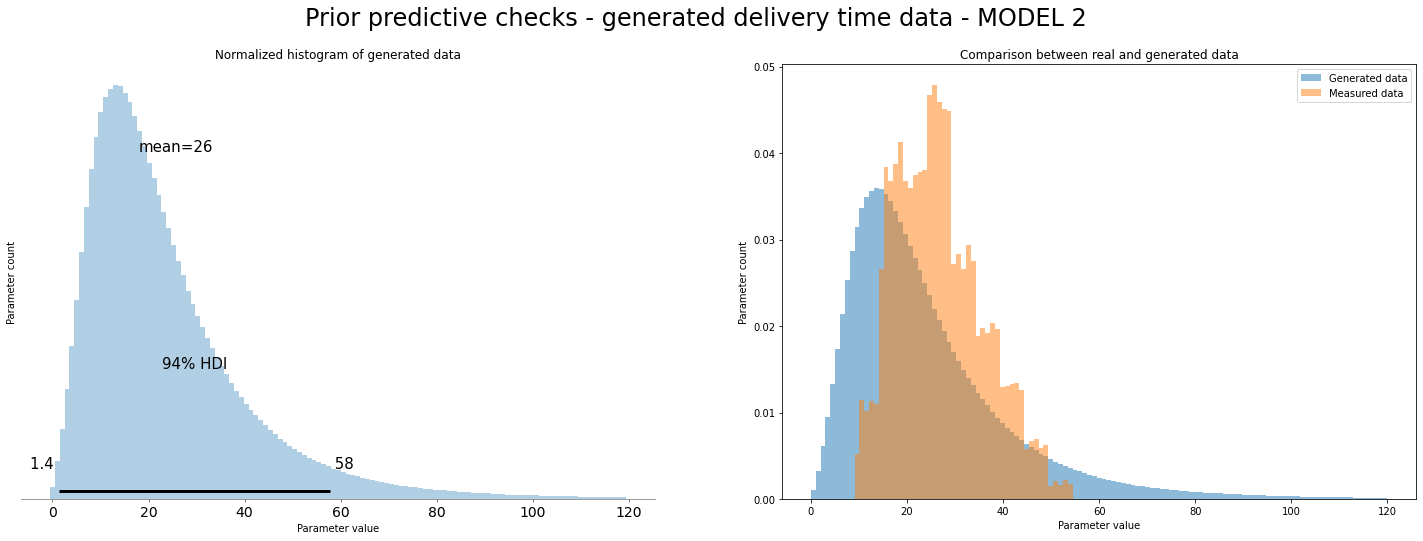

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
count,56474.000000,56473.000000,56474.000000,56474.000000,56474.000000,56474.000000,56473.000000,56473.000000,56473.0
mean,25.680173,0.670666,20.865375,6.537497,20.142730,62.702794,975.481151,26.689592,1.0
std,6.849209,0.895108,27.479935,1.347103,0.662358,32.524234,89.849131,2.478474,0.0
min,-0.012000,0.003300,0.000000,-0.520000,-0.012000,0.000000,678.000000,19.000000,1.0
25%,24.000000,0.490000,15.000000,5.700000,20.000000,52.000000,904.000000,25.000000,1.0
50%,25.000000,0.570000,18.000000,6.500000,20.000000,58.000000,976.000000,27.000000,1.0
75%,26.000000,0.690000,21.000000,7.300000,20.000000,66.000000,1041.000000,28.000000,1.0
max,222.000000,30.000000,899.000000,10.000000,24.000000,1007.000000,1227.000000,34.000000,1.0


In [8]:
# plot preparation
fig, ax = plt.subplots(3,2, figsize=(25,15))
fig.suptitle("Prior checks for parameters used in link function - MODEL 2", fontsize=24)

# get distance coeff
model2_ppc_distance_coeff = model2_ppc_sim.stan_variable('distance_coeff')

# plot distance coeff
ax[0,0].hist(model2_ppc_distance_coeff,label="Distance coefficient", bins=np.linspace(-1.2,1.2,50))
ax[0,0].legend()
ax[0,0].set_xlabel("Parameter value")
ax[0,0].set_ylabel("Parameter count")
ax[0,0].set_title("Histogram of distance coefficients")

# get meal_prep_coeff coeff
model2_ppc_meal_prep_coeff = model2_ppc_sim.stan_variable('meal_prep_coeff')

# plot meal_prep_coeff coeff
ax[0,1].hist(model2_ppc_meal_prep_coeff,label="Meal preparation time coefficient", bins=np.linspace(-1.2,1.2,50))
ax[0,1].legend()
ax[0,1].set_xlabel("Parameter value")
ax[0,1].set_ylabel("Parameter count")
ax[0,1].set_title("Histogram of meal preparation time coefficients")

# get mean
model2_ppc_mean = model2_ppc_sim.stan_variable('mean')

# plot mean
ax[1,0].hist(model2_ppc_mean,label="Mean intercept", bins=np.linspace(2.5,3.5,50))
ax[1,0].legend()
ax[1,0].set_xlabel("Parameter value")
ax[1,0].set_ylabel("Parameter count")
ax[1,0].set_title("Histogram of mean intercept")

# get traffic level coeff
model2_ppc_traffic_coeff = model2_ppc_sim.stan_variable('traffic_level_coeff')

# plot traffic coeff
ax[1,1].hist(model2_ppc_traffic_coeff[:,0],label="Jam", alpha=0.3, bins=np.linspace(-1.2,1.2,50))
ax[1,1].hist(model2_ppc_traffic_coeff[:,1],label="High", alpha=0.3, bins=np.linspace(-1.2,1.2,50))
ax[1,1].hist(model2_ppc_traffic_coeff[:,2],label="Medium", alpha=0.3, bins=np.linspace(-1.2,1.2,50))
ax[1,1].hist(model2_ppc_traffic_coeff[:,3],label="Low", alpha=0.3, bins=np.linspace(-1.2,1.2,50))
ax[1,1].legend()
ax[1,1].set_xlabel("Parameter value")
ax[1,1].set_ylabel("Parameter count")
ax[1,1].set_title("Histogram of traffic level coefficients")

# get delivery person rating coeff
model2_ppc_mean = model2_ppc_sim.stan_variable('person_rating_coeff')

# plot elivery person rating coeff
ax[2,0].hist(model2_ppc_mean,label="Delivery person rating coefficient", bins=np.linspace(-1.2,1.2,50))
ax[2,0].legend()
ax[2,0].set_xlabel("Parameter value")
ax[2,0].set_ylabel("Parameter count")
ax[2,0].set_title("Histogram of delivery person rating coefficients")

# get number of deliveries coeffs
model2_ppc_traffic_coeff = model2_ppc_sim.stan_variable('deliveries_number_coeff')

# plot traffic coeff
ax[2,1].hist(model2_ppc_traffic_coeff[:,0],label="0 deliveries", alpha=0.3, bins=np.linspace(-1.2,1.2,50))
ax[2,1].hist(model2_ppc_traffic_coeff[:,1],label="1 delivery", alpha=0.3, bins=np.linspace(-1.2,1.2,50))
ax[2,1].hist(model2_ppc_traffic_coeff[:,2],label="2 deliveries", alpha=0.3, bins=np.linspace(-1.2,1.2,50))
ax[2,1].hist(model2_ppc_traffic_coeff[:,3],label="3 deliveries", alpha=0.3, bins=np.linspace(-1.2,1.2,50))
ax[2,1].legend()
ax[2,1].set_xlabel("Parameter value")
ax[2,1].set_ylabel("Parameter count")
ax[2,1].set_title("Histogram of deliveries numbers coefficients")
plt.show()

#-------------------------------------PARAMS FOR MODEL-------------------------------------------------
# plot preparation
fig1, ax1= plt.subplots(1,2, figsize=(25,8))
fig1.suptitle("Prior checks for parameters used in likelihood - MODEL 2", fontsize=24)

# get distance coeff (flatten because its MxN matrix (data samples x algo samples))
model2_ppc_mu = model2_ppc_sim.stan_variable('mu').flatten()

# plot distance coeff
az.plot_posterior(model2_ppc_mu, kind='hist', ax=ax1[0], bins=np.linspace(0,100,50), group='prior')
ax1[0].set_frame_on(True)
ax1[0].set_xlabel("Parameter value")
ax1[0].set_ylabel("Parameter count")
ax1[0].set_title("Histogram of mu (mean of delivery time)")

# get meal_prep_coeff coeff
model2_ppc_sigma = model2_ppc_sim.stan_variable('sigma')

# plot meal_prep_coeff coeff
ax1[1].hist(model2_ppc_sigma,label="Standard deviation", bins=np.linspace(0,15,50))
ax1[1].legend()
ax1[1].set_xlabel("Parameter value")
ax1[1].set_ylabel("Parameter count")
ax1[1].set_title("Histogram of standard deviation of delivery time")
plt.show()

#--------------------------------------PPC MEASUREMENTS------------------------------------------------------

fig2, ax2= plt.subplots(1,2, figsize=(25,8))
fig2.suptitle("Prior predictive checks - generated delivery time data - MODEL 2", fontsize=24)

# get measurements
model2_ppc_measurements = model2_ppc_sim.stan_variable('delivery_times').flatten()  # flatten makes it row/column vector (one of these)

# set bins
bins = np.linspace(0, 120, 120)

az.plot_posterior(model2_ppc_measurements, kind='hist', ax=ax2[0], bins=bins, group='prior', backend="matplotlib")
ax2[0].set_xlabel("Parameter value")
ax2[0].set_ylabel("Parameter count")
ax2[0].set_title("Normalized histogram of generated data")

# plot measurements
ax2[1].hist(model2_ppc_measurements, density=True, bins=bins,  alpha=0.5, label="Generated data")

# compare with real data, density set to True because each data point sampled 999 times
ax2[1].hist(train_df["Time_taken(min)"], density=True, bins=bins, alpha=0.5, label="Measured data")
ax2[1].legend()
ax2[1].set_xlabel("Parameter value")
ax2[1].set_ylabel("Parameter count")
ax2[1].set_title("Comparison between real and generated data")
plt.show()

# display summary
model2_ppc_sim.summary().describe()

In [9]:
# load model from previously sampled csvs
model2_sample = from_csv('/home/project_repo/data_analytics_project/models_output/model2/fit')

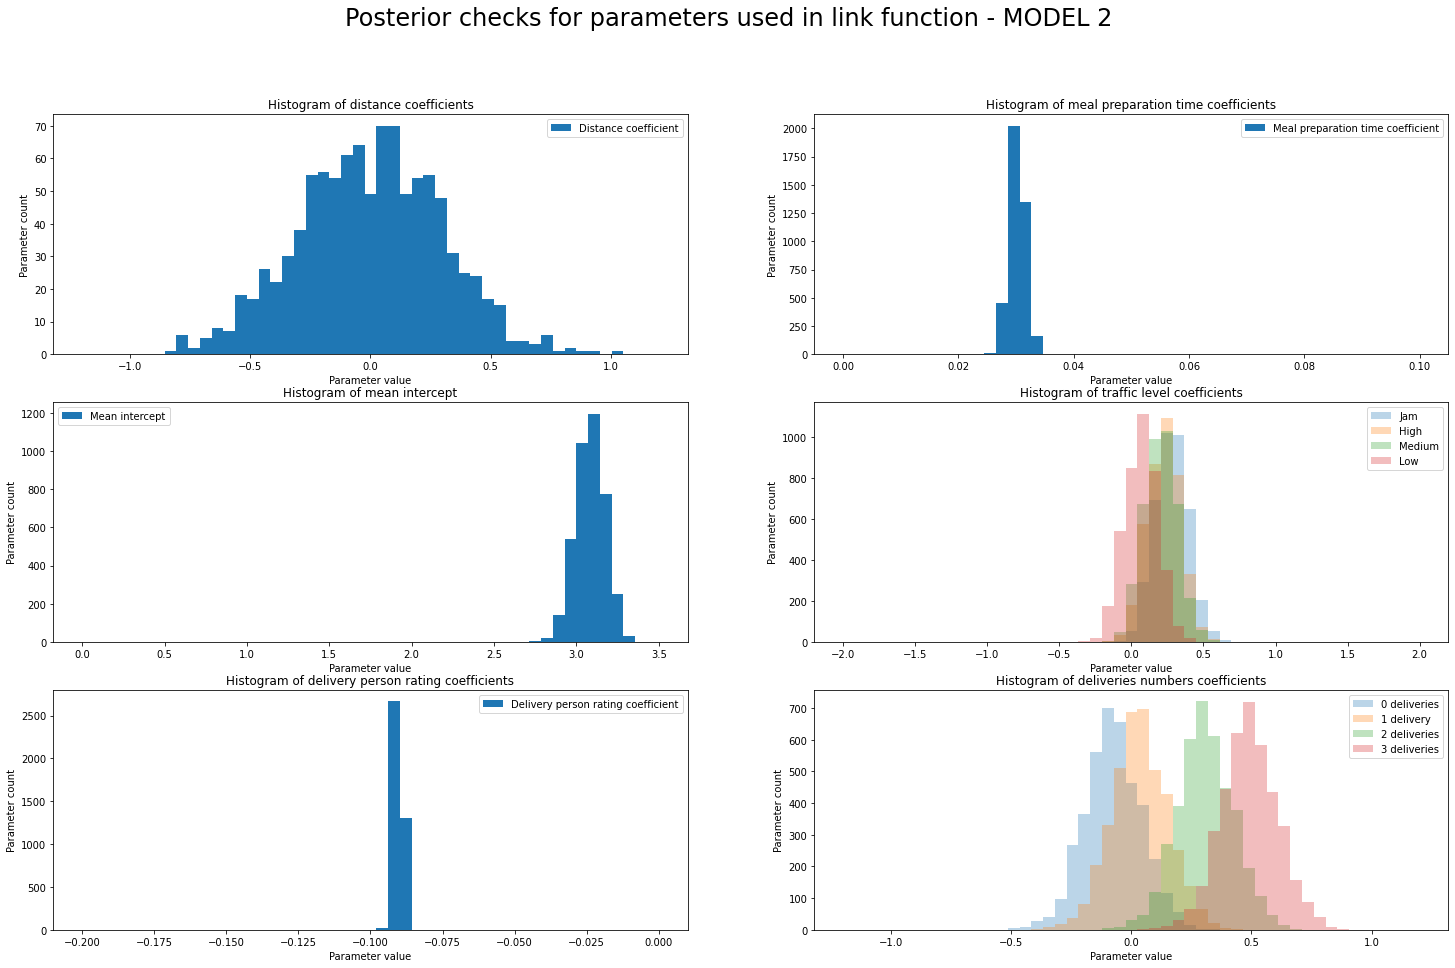

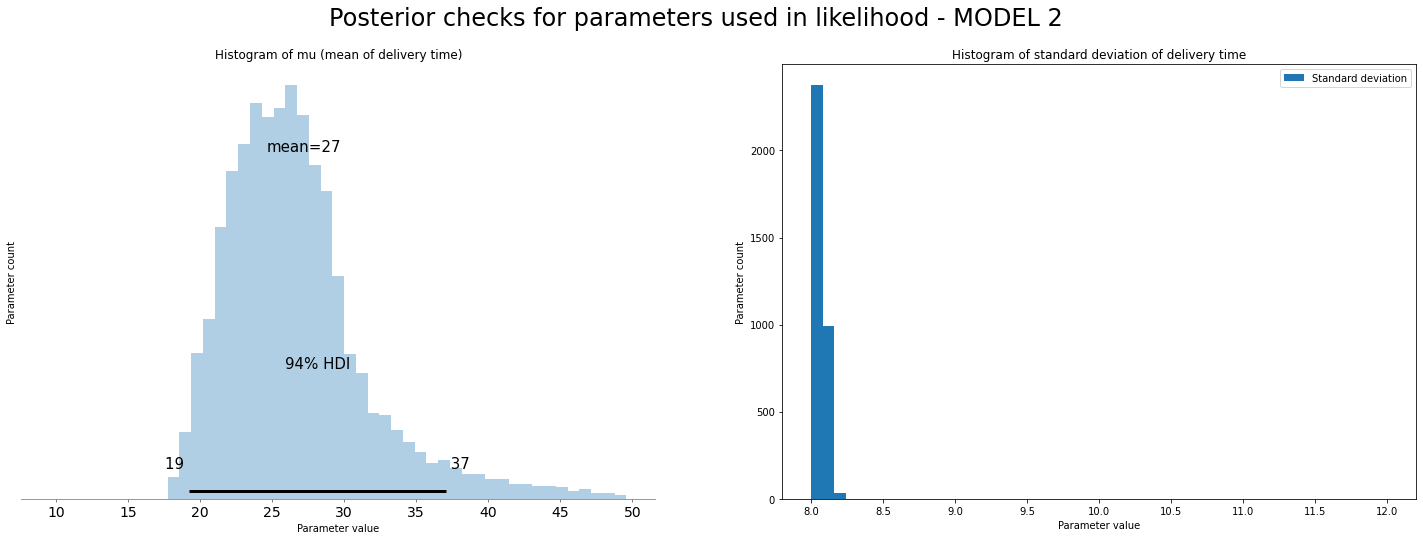

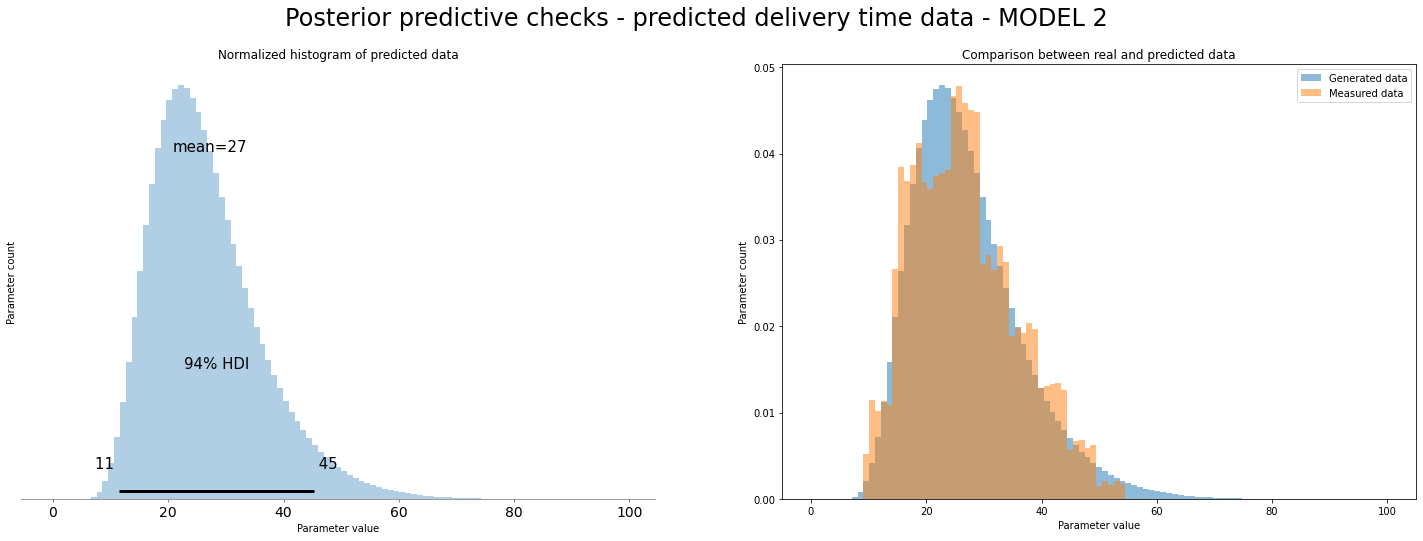

: 

: 

In [10]:
# plot preparation
fig, ax = plt.subplots(3,2, figsize=(25,15))
fig.suptitle("Posterior checks for parameters used in link function - MODEL 2", fontsize=24)

# get distance coeff
model2_fit_distance_coeff = model2_sample.stan_variable('distance_coeff')

# plot distance coeff
ax[0,0].hist(model2_ppc_distance_coeff,label="Distance coefficient", bins=np.linspace(-1.2,1.2,50))
ax[0,0].legend()
ax[0,0].set_xlabel("Parameter value")
ax[0,0].set_ylabel("Parameter count")
ax[0,0].set_title("Histogram of distance coefficients")

# get meal_prep_coeff coeff
model2_fit_meal_prep_coeff = model2_sample.stan_variable('meal_prep_coeff')

# plot meal_prep_coeff coeff
ax[0,1].hist(model2_fit_meal_prep_coeff,label="Meal preparation time coefficient", bins=np.linspace(0,0.1,50))
ax[0,1].legend()
ax[0,1].set_xlabel("Parameter value")
ax[0,1].set_ylabel("Parameter count")
ax[0,1].set_title("Histogram of meal preparation time coefficients")

# get mean
model2_fit_mean = model2_sample.stan_variable('mean')

# plot mean
ax[1,0].hist(model2_fit_mean,label="Mean intercept", bins=np.linspace(0,3.5,50))
ax[1,0].legend()
ax[1,0].set_xlabel("Parameter value")
ax[1,0].set_ylabel("Parameter count")
ax[1,0].set_title("Histogram of mean intercept")

# get traffic level coeff
model2_fit_traffic_coeff = model2_sample.stan_variable('traffic_level_coeff')

# plot traffic coeff
ax[1,1].hist(model2_fit_traffic_coeff[:,0],label="Jam", alpha=0.3, bins=np.linspace(-2,2,50))
ax[1,1].hist(model2_fit_traffic_coeff[:,1],label="High", alpha=0.3, bins=np.linspace(-2,2,50))
ax[1,1].hist(model2_fit_traffic_coeff[:,2],label="Medium", alpha=0.3, bins=np.linspace(-2,2,50))
ax[1,1].hist(model2_fit_traffic_coeff[:,3],label="Low", alpha=0.3, bins=np.linspace(-2,2,50))
ax[1,1].legend()
ax[1,1].set_xlabel("Parameter value")
ax[1,1].set_ylabel("Parameter count")
ax[1,1].set_title("Histogram of traffic level coefficients")

# get delivery person rating coeff
model2_fit_person_rating = model2_sample.stan_variable('person_rating_coeff')

# plot elivery person rating coeff
ax[2,0].hist(model2_fit_person_rating,label="Delivery person rating coefficient", bins=np.linspace(-0.2,0,50))
ax[2,0].legend()
ax[2,0].set_xlabel("Parameter value")
ax[2,0].set_ylabel("Parameter count")
ax[2,0].set_title("Histogram of delivery person rating coefficients")

# get number of deliveries coeffs
model2_fit_delivery_number_coeff = model2_sample.stan_variable('deliveries_number_coeff')

# plot traffic coeff
ax[2,1].hist(model2_fit_delivery_number_coeff[:,0],label="0 deliveries", alpha=0.3, bins=np.linspace(-1.2,1.2,50))
ax[2,1].hist(model2_fit_delivery_number_coeff[:,1],label="1 delivery", alpha=0.3, bins=np.linspace(-1.2,1.2,50))
ax[2,1].hist(model2_fit_delivery_number_coeff[:,2],label="2 deliveries", alpha=0.3, bins=np.linspace(-1.2,1.2,50))
ax[2,1].hist(model2_fit_delivery_number_coeff[:,3],label="3 deliveries", alpha=0.3, bins=np.linspace(-1.2,1.2,50))
ax[2,1].legend()
ax[2,1].set_xlabel("Parameter value")
ax[2,1].set_ylabel("Parameter count")
ax[2,1].set_title("Histogram of deliveries numbers coefficients")
plt.show()


#-------------------------------------PARAMS FOR MODEL-------------------------------------------------
# plot preparation
fig1, ax1= plt.subplots(1,2, figsize=(25,8))
fig1.suptitle("Posterior checks for parameters used in likelihood - MODEL 2", fontsize=24)

# get distance coeff (flatten because its MxN matrix (data samples x algo samples))
model2_fit_mu = model2_sample.stan_variable('mu').flatten()

# plot distance coeff
az.plot_posterior(model2_fit_mu, kind='hist', ax=ax1[0], bins=np.linspace(10,50,50), group='prior')
ax1[0].set_frame_on(True)
ax1[0].set_xlabel("Parameter value")
ax1[0].set_ylabel("Parameter count")
ax1[0].set_title("Histogram of mu (mean of delivery time)")

# get meal_prep_coeff coeff
model2_fit_sigma = model2_sample.stan_variable('sigma')

# plot meal_prep_coeff coeff
ax1[1].hist(model2_fit_sigma,label="Standard deviation", bins=np.linspace(8,12,50))
ax1[1].legend()
ax1[1].set_xlabel("Parameter value")
ax1[1].set_ylabel("Parameter count")
ax1[1].set_title("Histogram of standard deviation of delivery time")
plt.show()

#--------------------------------------PPC MEASUREMENTS------------------------------------------------------

fig2, ax2= plt.subplots(1,2, figsize=(25,8))
fig2.suptitle("Posterior predictive checks - predicted delivery time data - MODEL 2", fontsize=24)

# get measurements
model2_fit_measurements = model2_sample.stan_variable('delivery_time').flatten()  # flatten makes it row/column vector (one of these)

# set bins
bins = np.linspace(0, 100, 100)

az.plot_posterior(model2_fit_measurements, kind='hist', ax=ax2[0], bins=bins, group='prior', backend="matplotlib")
ax2[0].set_xlabel("Parameter value")
ax2[0].set_ylabel("Parameter count")
ax2[0].set_title("Normalized histogram of predicted data")

# plot measurements
ax2[1].hist(model2_fit_measurements, density=True, bins=bins,  alpha=0.5, label="Generated data")

# compare with real data, density set to True because each data point sampled 999 times
ax2[1].hist(train_df["Time_taken(min)"], density=True, bins=bins, alpha=0.5, label="Measured data")
ax2[1].legend()
ax2[1].set_xlabel("Parameter value")
ax2[1].set_ylabel("Parameter count")
ax2[1].set_title("Comparison between real and predicted data")
plt.show()

# display summary
model2_sample.summary()

# Comparison

In [ ]:
model1_sample = from_csv('/home/project_repo/data_analytics_project/models_output/model1/fit')

# convert models to arviz format for comparison purposes
model1_az = az.from_cmdstanpy(
    posterior=model1_sample,
)

del model1_sample

model2_az = az.from_cmdstanpy(
    posterior=model2_sample,
)

# delete them, because they use too much RAM
del model2_sample

: 

: 

In [ ]:
compare_dict = {"model_1": model1_az, "model_2": model2_az}

# loo criterion
loo_diff = az.compare(compare_dict=compare_dict, ic="loo")
display(loo_diff)

ax = az.plot_compare(loo_diff)
ax.set_title("Comparison of models with LOO criterion")

# for safety
del loo_diff

In [ ]:
# waic criterion
waic_diff = az.compare(compare_dict=compare_dict, ic="waic")
display(waic_diff)

ax = az.plot_compare(loo_diff)
ax.set_title("Comparison of models with WAIC criterion")